# File formats analysis

In [1]:
import pandas as pd
import os
from pprint import pprint
import seaborn
from IPython import display
%matplotlib inline

## Load the data

In [2]:
requests = pd.read_csv("../data/muckrock-requests.csv").set_index("id")
requests.index.name = "request_id"

In [3]:
files = pd.read_csv("../data/muckrock-files.csv").set_index("request_id").join(pd.DataFrame({
    "request_slug": requests["slug"],
    "jurisdiction_name": requests["jurisdiction_name"],
    "agency_name": requests["agency_name"]
})).reset_index().set_index("id")

In [4]:
files.sample(5).T

id,25875,79696,75728,28202,36161
request_id,12865,23578,17618,10772,333
access,public,public,public,public,private
communication_id,95090,232723,228147,101642,129903
date,2014-08-18T10:23:58.616069,2016-03-03T00:00:00,2016-02-25T07:12:07.582426,2014-09-26T00:00:00,2015-02-23T14:32:51.521385
description,NaN,NaN,NaN,NaN,NaN
doc_id,1276692-goatscapingapproval,2759302-REPREADatabase594-pdf,NaN,1307548-d12-ebb-sp-800-90a-january-2012-pdf,1674382-2014-hqfo-00278_part1
ffile,https://d3gn0r3afghep.cloudfront.net/foia_file...,https://d3gn0r3afghep.cloudfront.net/foia_file...,https://d3gn0r3afghep.cloudfront.net/foia_file...,https://d3gn0r3afghep.cloudfront.net/foia_file...,https://d3gn0r3afghep.cloudfront.net/foia_file...
pages,2,1,0,136,1139
source,Boston City Clerk,San Diego County Sheriff's Department,Federal Bureau of Investigation,Department of Commerce,Department of Homeland Security
title,goatscapingapproval,REPREADatabase594.pdf,~WRD000,D12 EBB - SP 800-90A (January 2012).pdf,2014-HQFO-00278_Part1


## Extract file extensions

In [5]:
get_ext = lambda x: os.path.splitext(x)[1].lower()

In [6]:
files["file_ext"] = files["ffile"].apply(get_ext)

## Try to identify files that are most likely just letters

Far from perfect.

In [7]:
likely_letter_pat = (
    r"letter|acknowled|denial|denying|"
    r"request denied|no responsive|initial response|interim response|"
    r"request rejected|fix required|payment required"
)

In [8]:
files["is_likely_letter"] = (
    files["description"].str.contains(likely_letter_pat, case=False, na=False) |
    files["title"].str.contains(likely_letter_pat, case=False, na=False)
)

In [9]:
non_letters = files[files["is_likely_letter"] == False]

In [10]:
print("{0:.0f}% of files appear to be letters".format(files["is_likely_letter"].mean() * 100))

22% of files appear to be letters


In [11]:
print("{0:.0f}% of requests appear to include letter files"\
      .format((files.groupby("request_id")["is_likely_letter"].sum() > 0).mean() * 100))

57% of requests appear to include letter files


NOTE: Those numbers seem too low...

## What are the most common file formats?

For all files:

In [12]:
files["file_ext"].value_counts().head(15)

.pdf     44953
.jpg      7806
.msg      2236
.png      2093
.eml      1420
.xlsx     1099
.docx     1005
.doc       654
.zip       480
.gif       460
.xls       408
           402
.txt       135
.wav        97
.mp4        67
Name: file_ext, dtype: int64

For non-letters:

In [13]:
non_letters["file_ext"].value_counts().head(15)

.pdf     31617
.jpg      7803
.msg      2219
.png      2092
.eml      1405
.xlsx     1099
.docx      741
.doc       511
.zip       479
.gif       460
.xls       407
           395
.txt       135
.wav        97
.mp4        67
Name: file_ext, dtype: int64

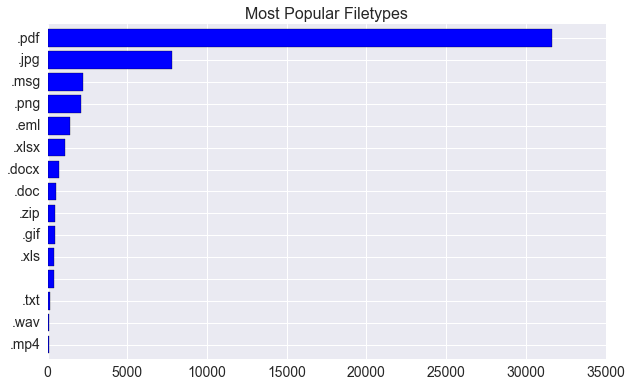

In [14]:
ax = non_letters["file_ext"].value_counts().head(15)\
    .plot(kind="barh", width=0.8, figsize=(10, 6), fontsize=14)
seaborn.mpl.pyplot.gca().invert_yaxis()
ax.set_title("Most Popular Filetypes", fontsize=16)
pass

## How many pages do PDF responses contains?

When MuckRock gets a PDF, it counts the number of pages.

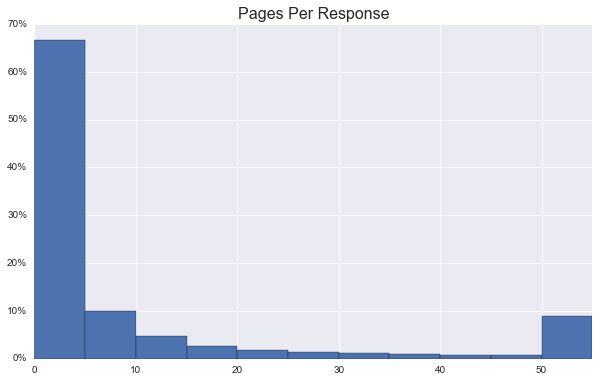

In [15]:
ax = non_letters[
    (non_letters["pages"] > 0) &
    (non_letters["is_likely_letter"] == False)
]["pages"]\
    .apply(lambda x: min(x, 55))\
    .hist(bins=range(0, 60, 5), normed=True, figsize=(10, 6))
ax.set_xlim((0, 55))
ax.set_title("Pages Per Response", fontsize=16)
ax.set_yticklabels([ "{0:.0f}%".format(y * 500) for y in ax.get_yticks() ])
pass

## What agencies have sent data in tabular data formats?

In [16]:
def count_responses_by_ext(exts):
    return pd.DataFrame({
        "n_responses": files[
            files["file_ext"].isin(exts)
        ].groupby([ "jurisdiction_name", "agency_name" ])["request_id"].nunique()\
            .sort_values(ascending=False)
    }).reset_index()

In [17]:
count_responses_by_ext([ ".csv", ".tsv", ".xls", ".xlsx" ]).head(15)

,jurisdiction_name,agency_name,n_responses
0,United States of America,Federal Trade Commission,37
1,"Boston, MA",Boston Police Department,14
2,"Seattle, WA",Seattle Police Department,9
3,United States of America,George W Bush (43) Presidential Library,7
4,Washington,Central Puget Sound Regional Transit Authority,6
5,United States of America,U.S. Citizenship and Immigration Services,4
6,"New York City, NY",Department of Health and Mental Hygiene,4
7,"Seattle, WA",Office of the Mayor,4
8,Massachusetts,Department of Education,4
9,"Somerville, MA",Somerville City Clerk,4


In [18]:
files[
    (files["file_ext"] == ".xls") &
    (files["agency_name"] == "Federal Trade Commission")
][[ "request_slug", "title", "description"]].fillna("")

,request_slug,title,description
id,,,
9515,ftc-complaints-for-any-complaints-that-may-hav...,Campbell Media Group.xls,
9516,ftc-complaints-for-any-complaints-that-may-hav...,John Campbell.xls,
10325,ftc-fedex-complaints,Responsive Documents,
12012,fy2013-foia-log-federal-trade-commission,Request log 10.1.2012-12.31.2012 Redacted.xls,
12013,fy2013-foia-log-federal-trade-commission,Request log 9.26.2013-9.30.2013 Redacted.xls,
12955,ftc-complaints-nfl,Responsive Documents,
18355,ftc-complaints-for-uber,Uber_complaints.xls,
28075,ftc-complaints-for-western-union-et-al,Western Union MA redacted.xml,


Generalize that code, so that we can look at any subset of extensions...

## How about .zip files?

In [19]:
count_responses_by_ext([ ".zip" ]).head(10)

,jurisdiction_name,agency_name,n_responses
0,United States of America,Immigration and Customs Enforcement,57
1,United States of America,Department of Homeland Security,12
2,"Boston, MA",Mayor's Office,5
3,United States of America,Federal Bureau of Investigation,4
4,United States of America,Food and Drug Administration,4
5,United States of America,National Park Service,4
6,"Boston, MA",Boston Redevelopment Authority,3
7,United States of America,Consumer Financial Protection Bureau,3
8,United States of America,Department of Transportation,3
9,"New York City, NY",New York City Police Department,3


### Oooh what are in those .zip files... ?

In [20]:
files[
    (files["file_ext"] == ".zip") &
    (files["agency_name"] == "Immigration and Customs Enforcement")
][[ "request_slug", "title", "description"]].fillna("")

,request_slug,title,description
id,,,
74559,guns-and-ammunition-purchased-in-fy2013,2015-ICFO-04708_141795,
41462,muckrock-request-processing-instructions-immig...,2015-ICFO-00843_61647,
36305,first-record-mentioning-the-marco-polo-task-force,2015-ICFO-00925_39854,
41463,fee-category-records-for-2014foia3508,2015-ICFO-02197_61654,
73557,ice-tpm-on-easton-amc-incident,2015-ICFO-00813_140344,
42232,proposed-records-schedules-ice,2015-ICFO-01103_63226,
28098,ices-statistics-on-deportation-through-the-287...,2014-ICFO-02026_11003,
39321,contracts-and-amendments-for-the-njs-elizabeth...,2014-ICFO-04417_53437,
37455,all-contracts-between-ice-and-geo-group-for-nj...,2014-ICFO-05862_45563,


In [21]:
print(files.loc[75501]["ffile"])

https://d3gn0r3afghep.cloudfront.net/foia_files/2016/02/22/2016-ICFO-15513_143128.zip


## Random Sound!

In [22]:
(files["file_ext"] == ".wav").sum()

97

In [23]:
sample_audio = files[
    (files["file_ext"] == ".wav")
].sample(1).iloc[0]
pprint(dict(sample_audio))
display.Audio(url=sample_audio["ffile"])

{'access': 'public',
 'agency_name': 'St. Louis County Police Department',
 'communication_id': 109317,
 'date': '2014-11-20T00:00:00',
 'description': nan,
 'doc_id': nan,
 'ffile': 'https://d3gn0r3afghep.cloudfront.net/foia_files/Recorded_on_11-Aug-2014_at_14.25.36_118EQA106266900_censored_1_1.wav',
 'file_ext': '.wav',
 'is_likely_letter': False,
 'jurisdiction_name': 'St. Louis County, MO',
 'pages': 0,
 'request_id': 13292,
 'request_slug': 'communications-with-faa-dhs-and-dla',
 'source': 'St. Louis County Police Department',
 'title': 'Recorded on 11-Aug-2014 at 14.25.36 (118EQ(A106266900) '
          'censored.wav'}


---

---

---